# Band Structure Visualization

This notebook presents some of the basics features that can be used to visualize Band Structure from a BigDFT logfile.
The only input which is needed is the logfile of the system, wuth a k-point meshi that is dense enough to achieve convergence of the result. The bans structure is then obtained via interpolation over the Brillouin Zone of the mesh defined in this way.
To use this notebook you must have installed in your system the [spglib](http://atztogo.github.io/spglib/python-spglib.html#python-spglib) and the [ASE](http://atztogo.github.io/spglib/python-spglib.html#python-spglib) python library, whose installation is really standard and can be done in few minutes.

Let us start by setting up the PYTHONPATH to the BigDFT installation directory.
Here we point to the sources as we do not know where the code is installed, but the directory below should be <build>/install/lib/python2.7/site-packages. However:

In [1]:
#write here the position of the BigDFT installation (usually <buildtree>/install/lib/pythonX.X/site-packages)
import os
BIGDFT_PYTHONDIR=os.path.abspath(
    os.path.join(os.pardir,os.pardir,'src','python')
    ) #refer to the sources, only for test 
#then update the path
import sys
if BIGDFT_PYTHONDIR not in sys.path: 
    sys.path+=[BIGDFT_PYTHONDIR]

Next we load a logfile which is suitable for the calculation, for example an evergreen (this log has been shortened for practical purposes):

In [2]:
import BigDFT.Logfiles as lf
%matplotlib inline
Graph=lf.Logfile('testfiles/log-Graphene.yaml')

In [3]:
#inform
print Graph

- Atom types:
  - C
- Cell:
  - 4.664990175052176
  - .inf
  - 8.08
- Convergence criterion on forces: 0.0
- Symmetry group: not prim.
- fermi_level: -0.155705235927535
- Number of Atoms: 4
- kpt_mesh:
  - 36
  - 1
  - 36
- No. of KS orbitals per k-point:
  - 16
  - 0



In [4]:
#How many k-points?
Graph.nkpt

361

To start the analysis, it might be interesting to plot the Density of States (also see the DoS example notebook):

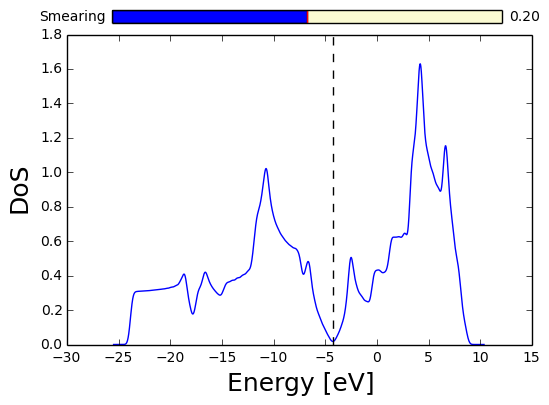

In [5]:
Graph.get_dos(label='C').plot()

Where we can see that the density of states at the fermi level is zero as it should.
Let us now instance the Brillouin Zone class:

In [6]:
GBZ=Graph.get_brillouin_zone()

lattice [[ 4.66499018  0.          0.        ]
 [ 0.          1.          0.        ]
 [ 0.          0.          8.08      ]]
spacegroup P6/mmm (191)
Lattice found: orthorhombic
irreductible k-points 361
Interpolation bias 1.19665729658e-08


The inspection of the symmetry of the system provides us with quantities that we might compare with the log properties above. The BrillouinZone class has also different attributes. In particulat we might be interested in kwowing the coorinates of the special points or the special paths of the corresponding structure:

In [7]:
dir(GBZ)

['__doc__',
 '__init__',
 '__module__',
 'fermi_energy',
 'interpolator',
 'lattice',
 'plot',
 'special_paths',
 'special_points']

In [8]:
#let us print the special points
import yaml
print yaml.dump(GBZ.special_points)

G: [0, 0, 0]
R: [0.5, 0.5, 0.5]
S: [0.5, 0.5, 0]
T: [0, 0.5, 0.5]
U: [0.5, 0, 0.5]
X: [0.5, 0, 0]
Y: [0, 0.5, 0]
Z: [0, 0, 0.5]



In [9]:
#and the special paths
print yaml.dump(GBZ.special_paths)

- [G, X, S, Y, G, Z, U, R, T, Z]
- [Y, T]
- [U, X]
- [S, R]



Let us now plot the band structure. Without specifying anything the plot is performed on the first special path, wrappend again at Gamma. We might also choose a fine discretization for the interpolation:

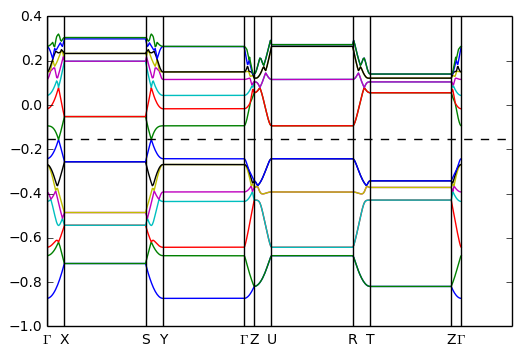

In [10]:
GBZ.plot(npts=5000)

This path does not really makes sense for graphene as it also involves points which have nonzero coordinate in the second index (which is a isolated direction according to BigDFT conventions)
We might of course also choose other paths:

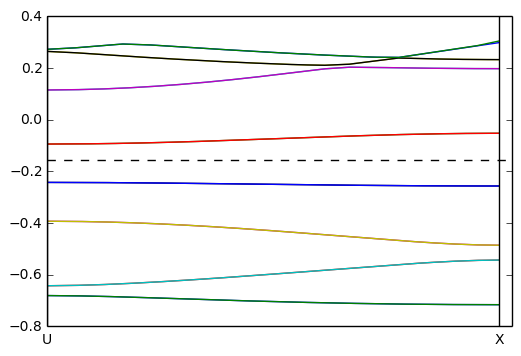

In [11]:
import BigDFT.BZ as BZ
reload(BZ)
path1=BZ.BZPath(GBZ.lattice,GBZ.special_paths[2],GBZ.special_points,npts=1000)
GBZ.plot(path=path1)

Or we might remove the points from the first path which have nonzero second coodinate:

['G', 'X', 'G', 'Z', 'U', 'Z', 'G']


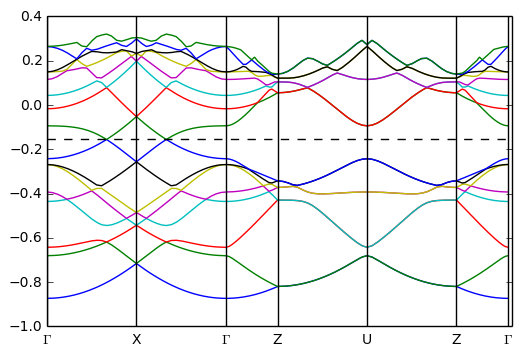

In [15]:
path0=[]
for p in GBZ.special_paths[0]+['G']:
    if GBZ.special_points[p][1]==0.0: path0.append(p)
print path0
path0=BZ.BZPath(GBZ.lattice,path0,GBZ.special_points,npts=1000)
GBZ.plot(path=path0)

Where we can see the K and K' points with zero gap.

Let us now construct a Customized path that passes through the point of zero gap.
But first, we should inspect the k-point eigenvalues to find the k-point coordinates which correspond to this:

In [149]:
import numpy
print numpy.argmin([numpy.min(abs(e-Graph.fermi_level)) for e in Graph.evals])

12


It seems that it is the k-point number 12 (or 13 in fortran index). Let us verify:

In [16]:
Kprime=Graph.evals[12]
print Kprime,Graph.fermi_level

[[-0.80165202 -0.61878306 -0.61878204 -0.54437378 -0.44170999 -0.39244162
  -0.35160253 -0.1557054  -0.15570507  0.07854858  0.07951626  0.13722721
   0.21181075  0.23551115  0.26708953  0.3204834 ]] -0.155705235928


Indeed it is so. Let us now check which is its coordinate. There are attributes of the BandArray instance Kprime which might be of interest to us:

In [17]:
#brilloiun zone coordinate
print Kprime.kpt
#kpoint weight
print Kprime.kwgt

[0.3333, 0.0, 0.0]
0.0015


Anyhow, let us create a path that passes through this point. As it is not among the list of special point (we provided Orthorhombic coordinates for the Graphene), we should create a path via ASE. This is automatically done by the BZ instance for special points.

In [18]:
path2=BZ.BZPath(GBZ.lattice,path=['G',{'Kp':Kprime.kpt},'X','G'],special_points=GBZ.special_points,npts=1000)

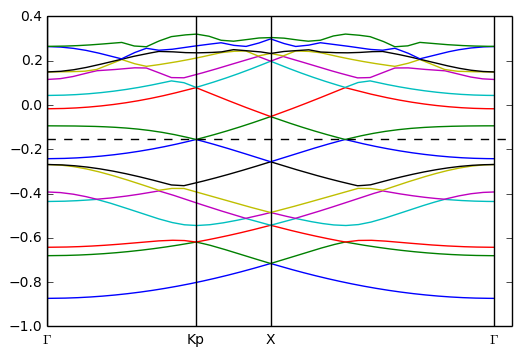

In [19]:
GBZ.plot(path=path2)

## Case of a 3d periodic (cubic) system

The same thing can be done for a cubic system, like the one already presented in the Logfile analysis example.
The following sections should be straightforward.

In [20]:
K=lf.Logfile('testfiles/log-K.yaml')

In [21]:
BZK=K.get_brillouin_zone()

lattice [[ 9.98888443  0.          0.        ]
 [ 0.          9.98888443  0.        ]
 [ 0.          0.          9.98888443]]
spacegroup Im-3m (229)
Lattice found: cubic
irreductible k-points 120
Interpolation bias 2.38385636069e-09


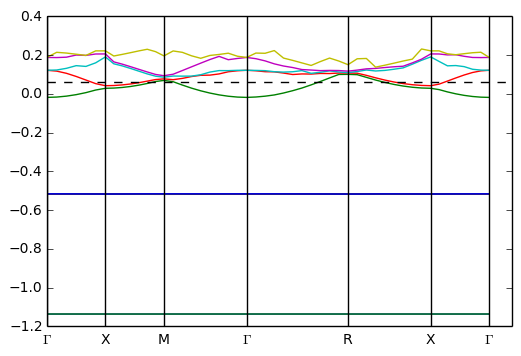

In [22]:
BZK.plot()